# Self made RP3-beta

In [29]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random
import time
import matplotlib.pyplot as plt

train_read = pd.read_csv("./Datasets/ml-100k/train.csv", sep="\t", header=None)
test_read = pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None)
(
    train_ui,
    test_ui,
    user_code_id,
    user_id_code,
    item_code_id,
    item_id_code,
) = helpers.data_to_csr(train_read, test_read)

In [30]:
class RP3Beta:
    def fit(self, train_ui, alpha, beta):
        """We weight our edges by user's explicit ratings so if user rated movie high we'll follow that path
        with higher probability."""
        self.train_ui = train_ui
        self.train_iu = train_ui.transpose()

        self.alpha = alpha
        self.beta = beta

        # Define Pui
        Pui = sparse.csr_matrix(self.train_ui / self.train_ui.sum(axis=1))

        # Define Piu
        to_divide = np.vectorize(lambda x: x if x > 0 else 1)(
            self.train_iu.sum(axis=1)
        )  # to avoid dividing by zero
        Piu = sparse.csr_matrix(self.train_iu / to_divide)
        item_orders = (self.train_ui > 0).sum(axis=0)

        Pui = Pui.power(self.alpha)
        Piu = Piu.power(self.alpha)

        P3 = Pui * Piu * Pui

        P3 /= np.power(
            np.vectorize(lambda x: x if x > 0 else 1)(item_orders), self.beta
        )

        self.estimations = np.array(P3)

    def recommend(self, user_code_id, item_code_id, topK=10):

        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):

            user_rated = self.train_ui.indices[
                self.train_ui.indptr[nb_user] : self.train_ui.indptr[nb_user + 1]
            ]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result = []
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid] + list(chain(*item_scores[:topK])))
        return result

    def estimate(self, user_code_id, item_code_id, test_ui):
        result = []
        for user, item in zip(*test_ui.nonzero()):
            result.append(
                [
                    user_code_id[user],
                    item_code_id[item],
                    self.estimations[user, item]
                    if not np.isnan(self.estimations[user, item])
                    else 1,
                ]
            )
        return result

In [31]:
model = RP3Beta()
model.fit(train_ui, alpha=1, beta=0)

In [32]:
top_n = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv(
    "Recommendations generated/ml-100k/Self_P3_reco.csv", index=False, header=False
)

estimations = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv(
    "Recommendations generated/ml-100k/Self_P3_estimations.csv",
    index=False,
    header=False,
)

In [33]:
import evaluation_measures as ev

estimations_df = pd.read_csv(
    "Recommendations generated/ml-100k/Self_P3_estimations.csv", header=None
)
reco = np.loadtxt("Recommendations generated/ml-100k/Self_P3_reco.csv", delimiter=",")

ev.evaluate(
    test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
    estimations_df=estimations_df,
    reco=reco,
    super_reactions=[4, 5],
)

943it [00:00, 6688.11it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  3.702446  3.527273   0.282185  0.192092  0.186749  0.21698   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   

         HR       H2R  Reco in test  Test coverage   Shannon      Gini  
0  0.875928  0.685048           1.0       0.077201  3.875892  0.974947

# Let's check hyperparameters

##### Alpha

In [34]:
from tqdm import tqdm

result = []
for alpha in tqdm([round(i, 1) for i in np.arange(0.2, 1.6001, 0.2)]):
    model = RP3Beta()
    model.fit(train_ui, alpha=alpha, beta=0)
    reco = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append = ev.evaluate(
        test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
        estimations_df=estimations_df,
        reco=np.array(reco),
        super_reactions=[4, 5],
    )
    to_append.insert(0, "Alpha", alpha)
    result.append(to_append)

result = pd.concat(result)
result

  0%|          | 0/8 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 6739.04it/s]
 12%|█▎        | 1/8 [00:14<01:39, 14.21s/it]
0it [00:00, ?it/s]
943it [00:00, 7360.08it/s]
 25%|██▌       | 2/8 [00:27<01:23, 13.94s/it]
0it [00:00, ?it/s]
943it [00:00, 7002.14it/s]
 38%|███▊      | 3/8 [00:40<01:07, 13.42s/it]
0it [00:00, ?it/s]
943it [00:00, 7273.46it/s]
 50%|█████     | 4/8 [00:54<00:54, 13.61s/it]
0it [00:00, ?it/s]
943it [00:00, 7058.66it/s]
 62%|██████▎   | 5/8 [01:08<00:40, 13.66s/it]
0it [00:00, ?it/s]
943it [00:00, 7147.76it/s]
 75%|███████▌  | 6/8 [01:22<00:27, 13.81s/it]
0it [00:00, ?it/s]
943it [00:00, 7094.19it/s]
 88%|████████▊ | 7/8 [01:36<00:13, 13.90s/it]
0it [00:00, ?it/s]
943it [00:00, 7123.37it/s]
100%|██████████| 8/8 [01:49<00:00, 13.73s/it]


Alpha        RMSE         MAE  precision    recall       F_1      F_05  \
0    0.2  268.177832  211.732649   0.262672  0.166858  0.166277  0.197184   
0    0.4   10.546689    7.792373   0.268505  0.172669  0.171569  0.202643   
0    0.6    3.143988    2.948790   0.274655  0.180502  0.177820  0.208730   
0    0.8    3.670728    3.495735   0.281972  0.189868  0.185300  0.216071   
0    1.0    3.702446    3.527273   0.282185  0.192092  0.186749  0.216980   
0    1.2    3.704441    3.529251   0.280912  0.193633  0.187311  0.216872   
0    1.4    3.704580    3.529388   0.273595  0.190651  0.183874  0.212183   
0    1.6    3.704591    3.529399   0.263097  0.186255  0.178709  0.205170   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.187661      0.203252  0.320910  0.196132  0.563378  0.580866   
0         0.192489      0.212653  0.326760  0.200172  0.565148  0.583801   
0         0.198176      0.222746  0.332872  0.203290  0.568872  0.587738   
0         0.203541      0.236751  0.339867  0.206688  0.573729  0.592432   
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.203004      0.240588  0.338049  0.203453  0.571830  0.594313   
0         0.199464      0.239118  0.329550  0.195433  0.566171  0.592793   
0         0.191094      0.232920  0.317439  0.184917  0.552349  0.590545   

         HR       H2R  Reco in test  Test coverage   Shannon      Gini  
0  0.850477  0.629905      1.000000       0.060606  3.669627  0.979636  
0  0.854719  0.644751      1.000000       0.064214  3.726996  0.978426  
0  0.870626  0.657476      1.000000       0.065657  3.785282  0.977090  
0  0.874867  0.685048      1.000000       0.070707  3.832415  0.975998  
0  0.875928  0.685048      1.000000       0.077201  3.875892  0.974947  
0  0.883351  0.681866      1.000000       0.085859  3.910718  0.974073  
0  0.871686  0.675504      1.000000       0.107504  3.961915  0.972674  
0  0.868505  0.669141      0.999576       0.156566  4.060156  0.969203

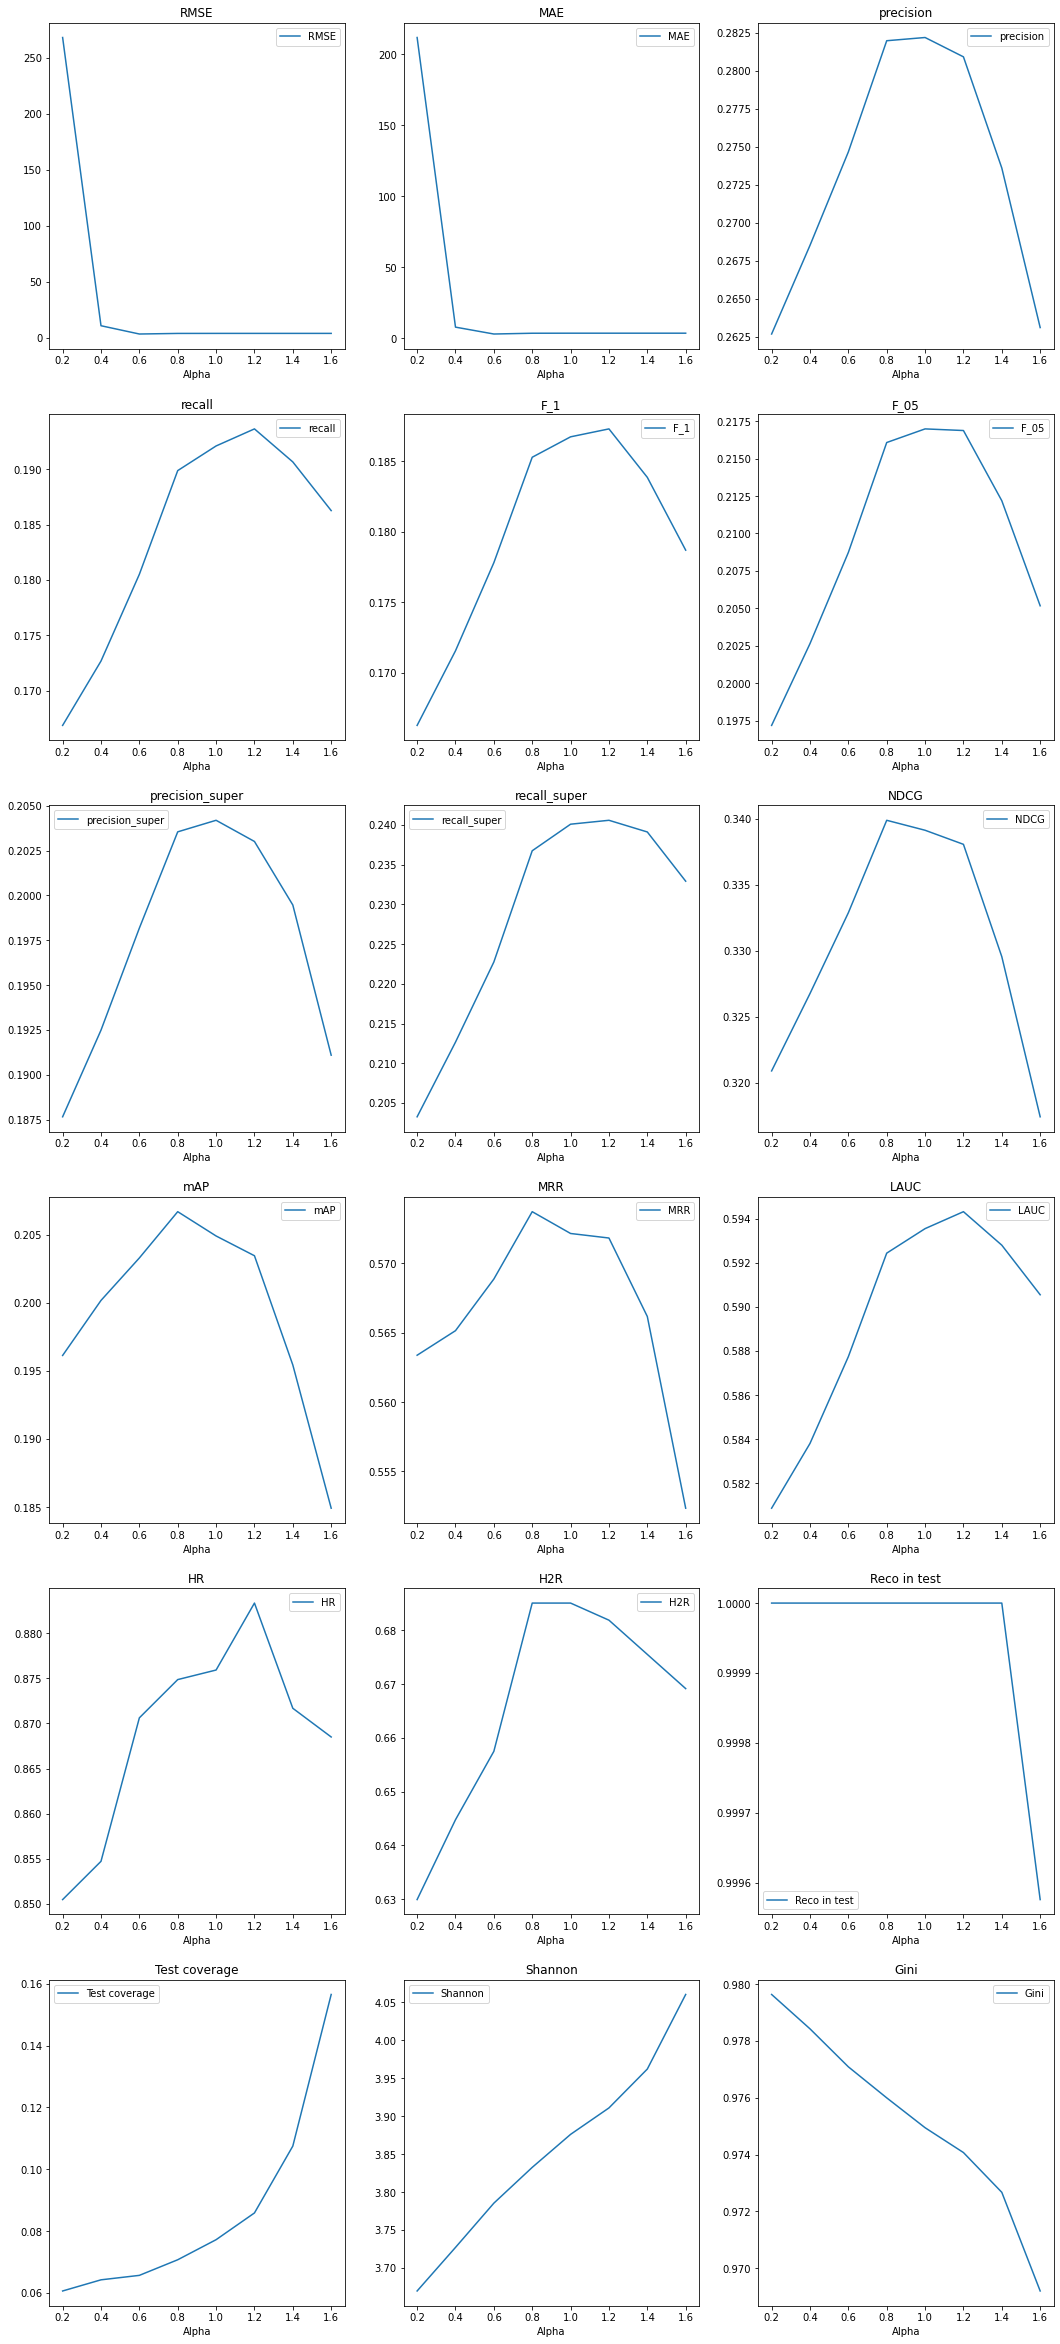

In [35]:
metrics = list(result.columns[[i not in ["Alpha"] for i in result.columns]])

charts_per_row = 6
charts_per_column = 3

fig, axes = plt.subplots(
    nrows=charts_per_row, ncols=charts_per_column, figsize=(18, 7 * charts_per_row)
)
import itertools

to_iter = [
    i for i in itertools.product(range(charts_per_row), range(charts_per_column))
]

for i in range(len(metrics)):
    df = result[["Alpha", metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

##### Beta

In [36]:
from tqdm import tqdm

result = []
for beta in tqdm([round(i, 1) for i in np.arange(0, 1, 0.1)]):
    model = RP3Beta()
    model.fit(train_ui, alpha=1, beta=beta)
    reco = pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
    estimations_df = pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
    to_append = ev.evaluate(
        test=pd.read_csv("./Datasets/ml-100k/test.csv", sep="\t", header=None),
        estimations_df=estimations_df,
        reco=np.array(reco),
        super_reactions=[4, 5],
    )
    to_append.insert(0, "Beta", beta)
    result.append(to_append)

result = pd.concat(result)
result

  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
943it [00:00, 7004.93it/s]
 10%|█         | 1/10 [00:13<02:05, 13.94s/it]
0it [00:00, ?it/s]
943it [00:00, 7040.39it/s]
 20%|██        | 2/10 [00:27<01:51, 13.96s/it]
0it [00:00, ?it/s]
943it [00:00, 7120.98it/s]
 30%|███       | 3/10 [00:41<01:37, 13.91s/it]
0it [00:00, ?it/s]
943it [00:00, 7008.88it/s]
 40%|████      | 4/10 [00:55<01:22, 13.80s/it]
0it [00:00, ?it/s]
943it [00:00, 7150.83it/s]
 50%|█████     | 5/10 [01:09<01:09, 13.83s/it]
0it [00:00, ?it/s]
943it [00:00, 7015.22it/s]
 60%|██████    | 6/10 [01:23<00:55, 13.81s/it]
0it [00:00, ?it/s]
943it [00:00, 5796.64it/s]
 70%|███████   | 7/10 [01:36<00:40, 13.57s/it]
0it [00:00, ?it/s]
943it [00:00, 7097.47it/s]
 80%|████████  | 8/10 [01:50<00:27, 13.72s/it]
0it [00:00, ?it/s]
943it [00:00, 7280.32it/s]
 90%|█████████ | 9/10 [02:03<00:13, 13.75s/it]
0it [00:00, ?it/s]
943it [00:00, 6231.86it/s]
100%|██████████| 10/10 [02:17<00:00, 13.73s/it]


Beta      RMSE       MAE  precision    recall       F_1      F_05  \
0   0.0  3.702446  3.527273   0.282185  0.192092  0.186749  0.216980   
0   0.1  3.703312  3.528128   0.290138  0.197597  0.192259  0.223336   
0   0.2  3.703825  3.528636   0.297137  0.201202  0.196067  0.228169   
0   0.3  3.704130  3.528939   0.303499  0.204749  0.199901  0.232829   
0   0.4  3.704313  3.529120   0.308908  0.208811  0.203854  0.237241   
0   0.5  3.704422  3.529229   0.314316  0.211411  0.206768  0.240986   
0   0.6  3.704488  3.529295   0.314634  0.206209  0.204818  0.240159   
0   0.7  3.704528  3.529335   0.304136  0.187298  0.191990  0.228749   
0   0.8  3.704552  3.529360   0.266384  0.147571  0.158660  0.194838   
0   0.9  3.704567  3.529375   0.162354  0.076967  0.089233  0.114583   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   
0         0.210944      0.246153  0.347768  0.212034  0.581038  0.596328   
0         0.218026      0.252767  0.355655  0.219909  0.588904  0.598160   
0         0.225107      0.260797  0.363757  0.226825  0.599969  0.599964   
0         0.229614      0.266918  0.370758  0.232673  0.609385  0.602014   
0         0.237124      0.273416  0.378307  0.239297  0.622792  0.603327   
0         0.242489      0.273850  0.376438  0.238428  0.622042  0.600721   
0         0.238305      0.256201  0.358807  0.226808  0.593897  0.591207   
0         0.214485      0.209336  0.299850  0.184356  0.492852  0.571152   
0         0.134657      0.113253  0.160868  0.085486  0.243590  0.535405   

         HR       H2R  Reco in test  Test coverage   Shannon      Gini  
0  0.875928  0.685048      1.000000       0.077201  3.875892  0.974947  
0  0.884411  0.695652      1.000000       0.085137  3.957416  0.972784  
0  0.886532  0.697773      1.000000       0.094517  4.053212  0.969980  
0  0.888653  0.707317      1.000000       0.105339  4.147779  0.966948  
0  0.895016  0.718982      0.999894       0.132035  4.259682  0.962989  
0  0.903499  0.724284      0.999046       0.168831  4.411281  0.956648  
0  0.897137  0.720042      0.996394       0.212843  4.621938  0.945932  
0  0.868505  0.693531      0.983033       0.256854  4.898568  0.928065  
0  0.803818  0.604454      0.936373       0.341270  5.257397  0.895882  
0  0.580064  0.400848      0.800106       0.415584  5.563910  0.857396

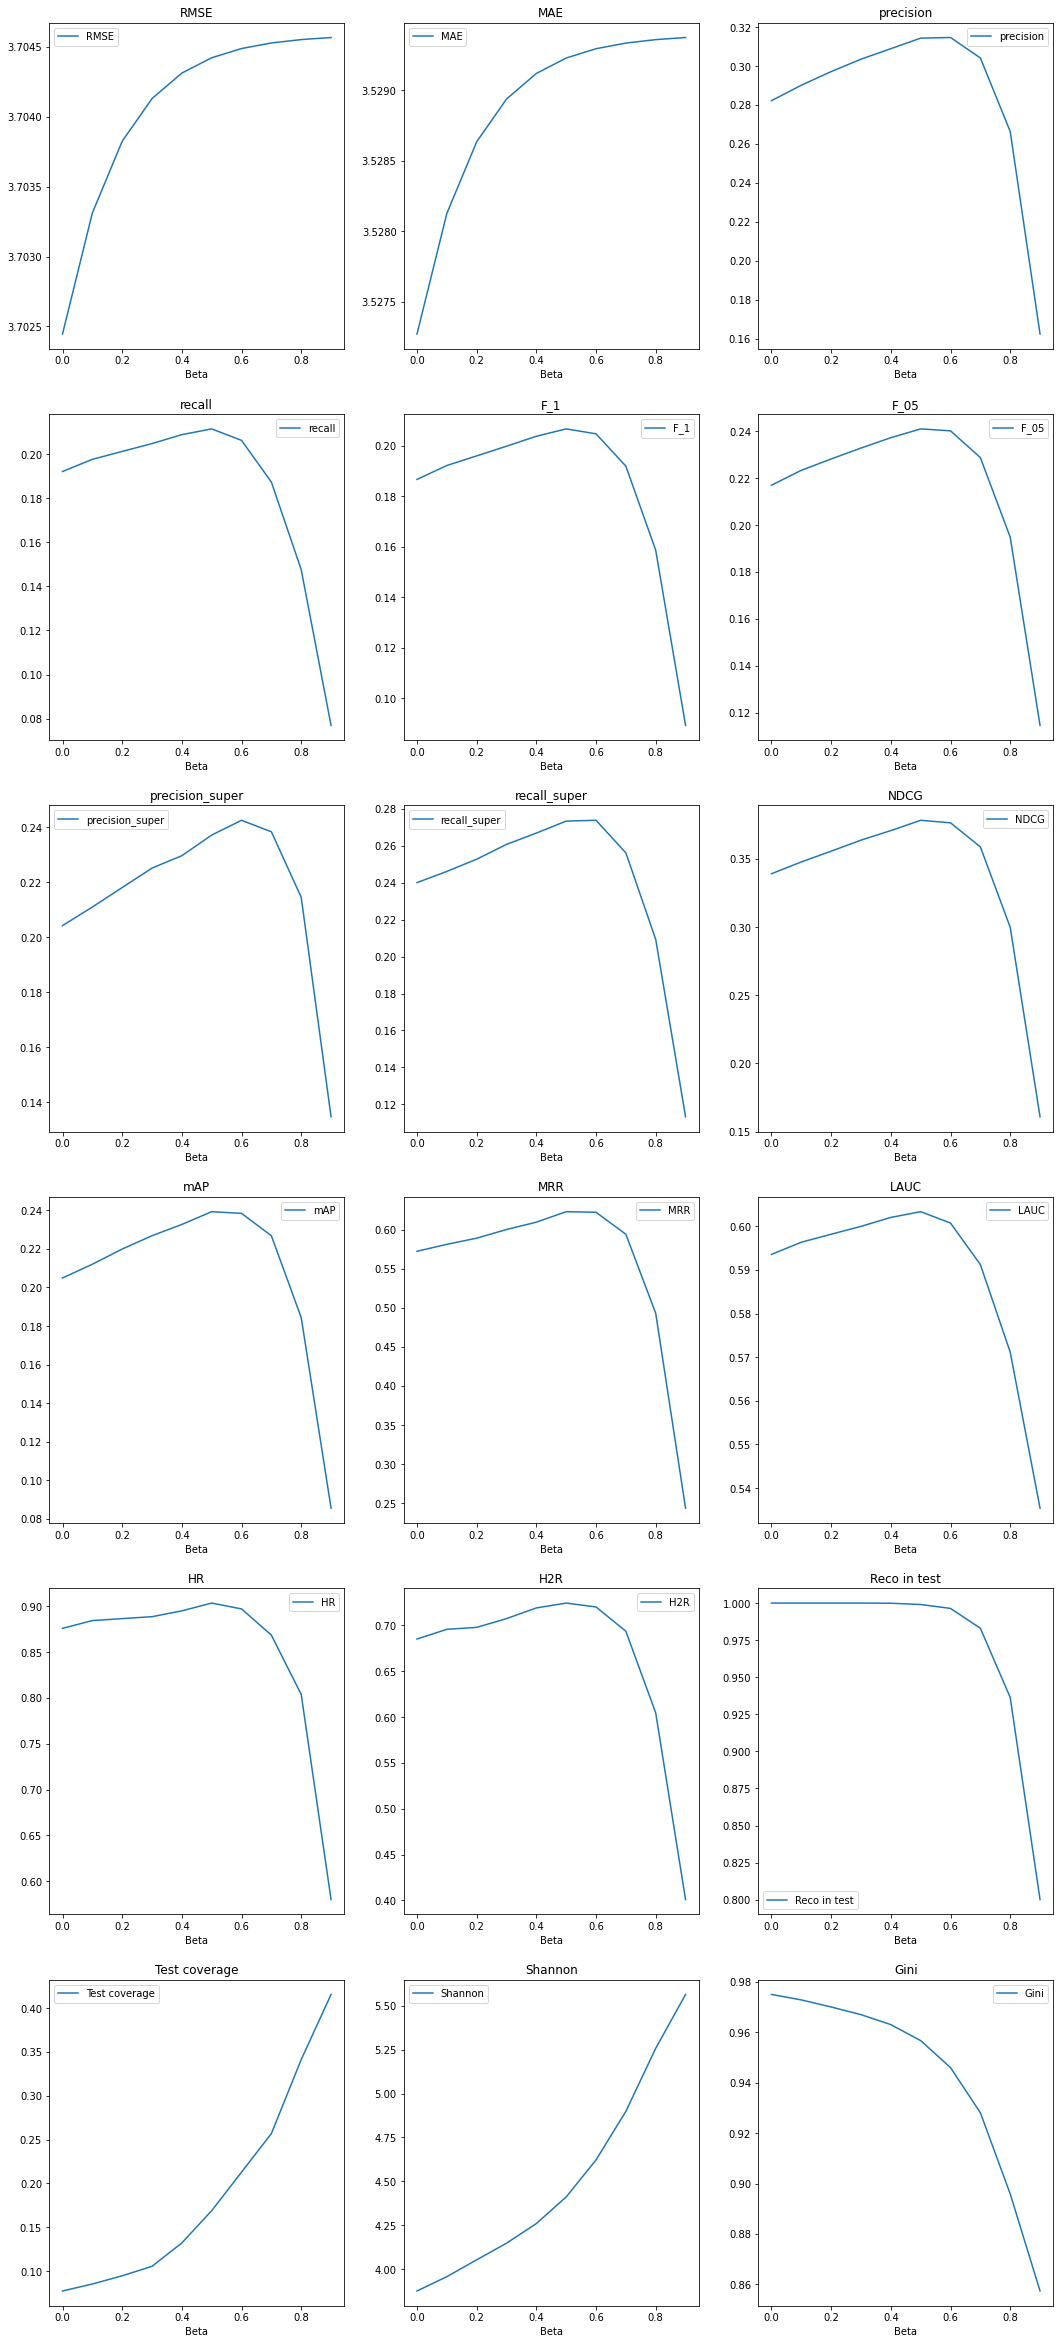

In [37]:
metrics = list(result.columns[[i not in ["Beta"] for i in result.columns]])

charts_per_row = 6
charts_per_column = 3

fig, axes = plt.subplots(
    nrows=charts_per_row, ncols=charts_per_column, figsize=(18, 7 * charts_per_row)
)
import itertools

to_iter = [
    i for i in itertools.product(range(charts_per_row), range(charts_per_column))
]

for i in range(len(metrics)):
    df = result[["Beta", metrics[i]]]
    df.plot(ax=axes[to_iter[i]], title=metrics[i], x=0, y=1)

# Check sample recommendations

In [38]:
train = pd.read_csv(
    "./Datasets/ml-100k/train.csv",
    sep="\t",
    header=None,
    names=["user", "item", "rating", "timestamp"],
)
items = pd.read_csv("./Datasets/ml-100k/movies.csv")

user = random.choice(list(set(train["user"])))

train_content = pd.merge(train, items, left_on="item", right_on="id")
display(
    train_content[train_content["user"] == user][
        ["user", "rating", "title", "genres"]
    ].sort_values(by="rating", ascending=False)[:15]
)

reco = np.loadtxt("Recommendations generated/ml-100k/Self_P3_reco.csv", delimiter=",")
items = pd.read_csv("./Datasets/ml-100k/movies.csv")

# Let's ignore scores - they are not used in evaluation:
reco_users = reco[:, :1]
reco_items = reco[:, 1::2]
# Let's put them into one array
reco = np.concatenate((reco_users, reco_items), axis=1)

# Let's rebuild it user-item dataframe
recommended = []
for row in reco:
    for rec_nb, entry in enumerate(row[1:]):
        recommended.append((row[0], rec_nb + 1, entry))
recommended = pd.DataFrame(recommended, columns=["user", "rec_nb", "item"])

recommended_content = pd.merge(recommended, items, left_on="item", right_on="id")
recommended_content[recommended_content["user"] == user][
    ["user", "rec_nb", "title", "genres"]
].sort_values(by="rec_nb")

user  rating                                 title  \
37092   169       5                        Contact (1997)   
3058    169       5                      Star Wars (1977)   
60433   169       5            Singin' in the Rain (1952)   
50247   169       5                        M*A*S*H (1970)   
73459   169       5                  All About Eve (1950)   
15015   169       5                Peacemaker, The (1997)   
18355   169       5                      Edge, The (1997)   
20398   169       5             Return of the Jedi (1983)   
40029   169       5                    Rear Window (1954)   
66194   169       5            In the Line of Fire (1993)   
25627   169       5                   Citizen Kane (1941)   
27344   169       5       Empire Strikes Back, The (1980)   
29621   169       4  Bridge on the River Kwai, The (1957)   
60206   169       4                     Birds, The (1963)   
41351   169       4             Gone with the Wind (1939)   

                                               genres  
37092                                   Drama, Sci-Fi  
3058          Action, Adventure, Romance, Sci-Fi, War  
60433                                Musical, Romance  
50247                                     Comedy, War  
73459                                           Drama  
15015                           Action, Thriller, War  
18355                             Adventure, Thriller  
20398         Action, Adventure, Romance, Sci-Fi, War  
40029                               Mystery, Thriller  
66194                                Action, Thriller  
25627                                           Drama  
27344  Action, Adventure, Drama, Romance, Sci-Fi, War  
29621                                      Drama, War  
60206                                          Horror  
41351                             Drama, Romance, War

user  rec_nb                             title  \
4481  169.0       1              Air Force One (1997)   
1012  169.0       2       English Patient, The (1996)   
6989  169.0       3                      Fargo (1996)   
4788  169.0       4                    Titanic (1997)   
1729  169.0       5                     Scream (1996)   
731   169.0       6  Silence of the Lambs, The (1991)   
5285  169.0       7                  Liar Liar (1997)   
5076  169.0       8            Full Monty, The (1997)   
3096  169.0       9                  Toy Story (1995)   
6097  169.0      10          L.A. Confidential (1997)   

                                   genres  
4481                     Action, Thriller  
1012                  Drama, Romance, War  
6989               Crime, Drama, Thriller  
4788               Action, Drama, Romance  
1729                     Horror, Thriller  
731                       Drama, Thriller  
5285                               Comedy  
5076                               Comedy  
3096        Animation, Children's, Comedy  
6097  Crime, Film-Noir, Mystery, Thriller

# project task 5: generate recommendations of RP3Beta for hyperparameters found to optimize recall

In [39]:
# We generated recommendations for P3, a special case of RP3Beta (with alpha=1, beta=0).
# We've observed that changing alpha and beta impacts the model performance.

# Your task is find values alpha and beta for which recall will be the highest 
# (any solution with recall higher than P3 will be accepted)
# train the model and generate recommendations.

# save the outptut in 'Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_RP3Beta_reco.csv'

import evaluation_measures as ev

model=RP3Beta()
model.fit(train_ui, alpha=1, beta=0) #check recall values for alpha=1, beta = 0
model_reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
model_reco.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', index=False, header=False)
estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations_df.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv', index=False, header=False)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 7035.65it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  3.702446  3.527273   0.282185  0.192092  0.186749  0.21698   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.204185      0.240096  0.339114  0.204905  0.572157  0.593544   

         HR       H2R  Reco in test  Test coverage   Shannon      Gini  
0  0.875928  0.685048           1.0       0.077201  3.875892  0.974947

In [40]:
import evaluation_measures as ev

model=RP3Beta()
model.fit(train_ui, alpha=0.6, beta=0.5) #check recall values for alpha=0.6, beta = 0.5
model_reco=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))
model_reco.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', index=False, header=False)
estimations_df=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations_df.to_csv('Recommendations generated/ml-100k/Self_RP3Beta_estimations.csv', index=False, header=False)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_RP3Beta_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 6914.18it/s]


RMSE       MAE  precision    recall       F_1     F_05  \
0  3.657073  3.481191   0.316543  0.213824  0.208731  0.24308   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.235515      0.272396  0.383442  0.245543  0.627971  0.604552   

         HR       H2R  Reco in test  Test coverage   Shannon     Gini  
0  0.903499  0.725345           1.0       0.125541  4.347845  0.95941

# project task 6 (optional): implement graph-based model of your choice 

In [41]:
# for example change length of paths in RP3beta or make some other modification (but change more than input and hyperparameters)
# feel free to implement your idea or search for some ideas

# save the outptut in 'Recommendations generated/ml-100k/Self_GraphTask_estimations.csv'
# and 'Recommendations generated/ml-100k/Self_GraphTask_reco.csv'